In [1]:
import pandas as pd
from cartopy import crs as ccrs
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
# import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean.cm as cmo
import cmocean
import gsw
from geopy import distance
import xesmf as xe
# import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


In [2]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [3]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmol kg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmol kg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmol kg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'deg C','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [4]:
def weighted_average(ds):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

### Compute sigma2 on Southern Ocean

In [5]:
ctrl_global = xr.open_dataset(datadir("CM4Xp125_piControl_SO_40S.nc"))
hist_global = xr.open_dataset(datadir("CM4Xp125_historical_SO_40S.nc"))

### Plot CFCs in Southern Ocean as a function of Depth and Time

In [126]:
#interpolation
interp_ctrl_timeseries = interpolate_section(ctrl_global, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")
interp_hist_timeseries = interpolate_section(hist_global, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "year")
interp_ctrl_timeseries.coords['year'] = interp_hist_timeseries.coords['year']

#define sigma levels
siglevels = np.arange(np.floor(ctrl_global.sigma2.min().values), 
                      37.4, .005) 
siglevels

array([35.   , 35.005, 35.01 , 35.015, 35.02 , 35.025, 35.03 , 35.035,
       35.04 , 35.045, 35.05 , 35.055, 35.06 , 35.065, 35.07 , 35.075,
       35.08 , 35.085, 35.09 , 35.095, 35.1  , 35.105, 35.11 , 35.115,
       35.12 , 35.125, 35.13 , 35.135, 35.14 , 35.145, 35.15 , 35.155,
       35.16 , 35.165, 35.17 , 35.175, 35.18 , 35.185, 35.19 , 35.195,
       35.2  , 35.205, 35.21 , 35.215, 35.22 , 35.225, 35.23 , 35.235,
       35.24 , 35.245, 35.25 , 35.255, 35.26 , 35.265, 35.27 , 35.275,
       35.28 , 35.285, 35.29 , 35.295, 35.3  , 35.305, 35.31 , 35.315,
       35.32 , 35.325, 35.33 , 35.335, 35.34 , 35.345, 35.35 , 35.355,
       35.36 , 35.365, 35.37 , 35.375, 35.38 , 35.385, 35.39 , 35.395,
       35.4  , 35.405, 35.41 , 35.415, 35.42 , 35.425, 35.43 , 35.435,
       35.44 , 35.445, 35.45 , 35.455, 35.46 , 35.465, 35.47 , 35.475,
       35.48 , 35.485, 35.49 , 35.495, 35.5  , 35.505, 35.51 , 35.515,
       35.52 , 35.525, 35.53 , 35.535, 35.54 , 35.545, 35.55 , 35.555,
      

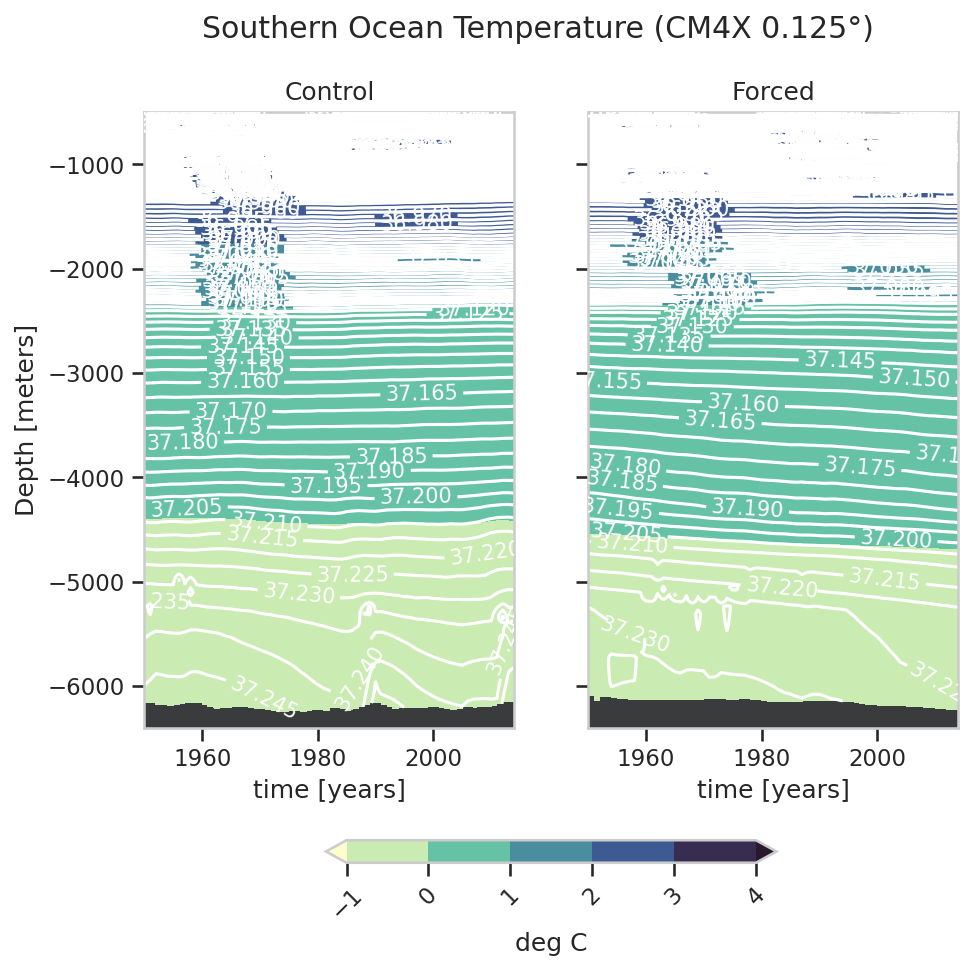

In [127]:
fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = False)
levels = np.arange(-1, 5)
tracer = "thetao"; tracername = "Temperature"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

tmp1 = interp_ctrl_timeseries[[tracer, "sigma2"]]
tmp1 = tmp1.sel(year = slice(1950, 2014)) 
ax[0].contourf(tmp1.year, tmp1.z, tmp1[tracer], cmap = cmo.deep, extend = "both", levels = levels)
cnt = ax[0].contour(tmp1.year, tmp1.z, tmp1.sigma2, levels = siglevels, colors = "white");
cs = ax[0].clabel(cnt, inline=True, fontsize=10)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

tmp2 = interp_hist_timeseries[[tracer, "sigma2"]]
tmp2 = tmp2.sel(year = slice(1950, 2014)) 
cm = ax[1].contourf(tmp2.year, tmp2.z, tmp2[tracer], cmap = cmo.deep, extend = "both", levels = levels)
cnt2 = ax[1].contour(tmp2.year, tmp2.z, tmp2.sigma2, colors = "white", levels = siglevels)
cs = ax[1].clabel(cnt2, inline=True, fontsize=10)
ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(-6400, -500) for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cm, ax = ax[0:2], label = variable_kwargs[tracer]["units"], 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)

# fig.savefig(plotsdir("paper_figures/SouthernOceanTemperature.png"), bbox_inches = "tight", dpi = 100)

In [128]:
#interpolation
interp_ctrl_timeseries = interpolate_section(ctrl_global, siglevels, interp_coord = "sigma2", iterate_coord = "year", kind = "linear")
interp_hist_timeseries = interpolate_section(hist_global, siglevels, interp_coord = "sigma2", iterate_coord = "year", kind = "linear")
interp_ctrl_timeseries.coords['year'] = interp_hist_timeseries.coords['year']

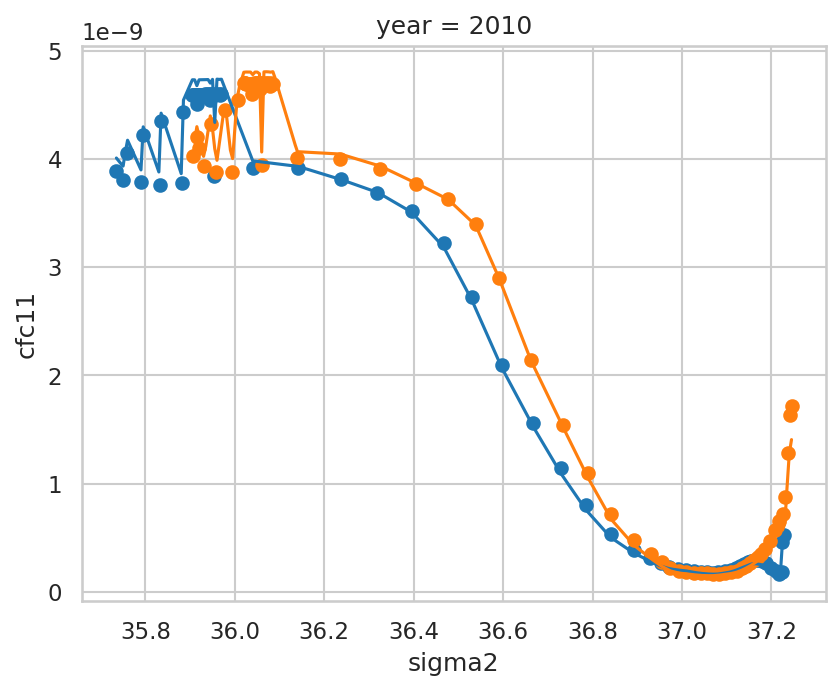

In [130]:
fig, ax = plt.subplots()
interp_hist_timeseries.isel(year = -5).cfc11.plot(ax = ax)
ax.scatter(hist_global.isel(year = -5)["sigma2"], hist_global.isel(year = -1)["cfc11"])

interp_ctrl_timeseries.isel(year = -5).cfc11.plot(ax = ax)
ax.scatter(ctrl_global.isel(year = -5)["sigma2"], ctrl_global.isel(year = -1)["cfc11"])

In [108]:
(hist_global.sigma2.min().values), ctrl_global.sigma2.max().values

(array(35.72586919), array(37.25735517))

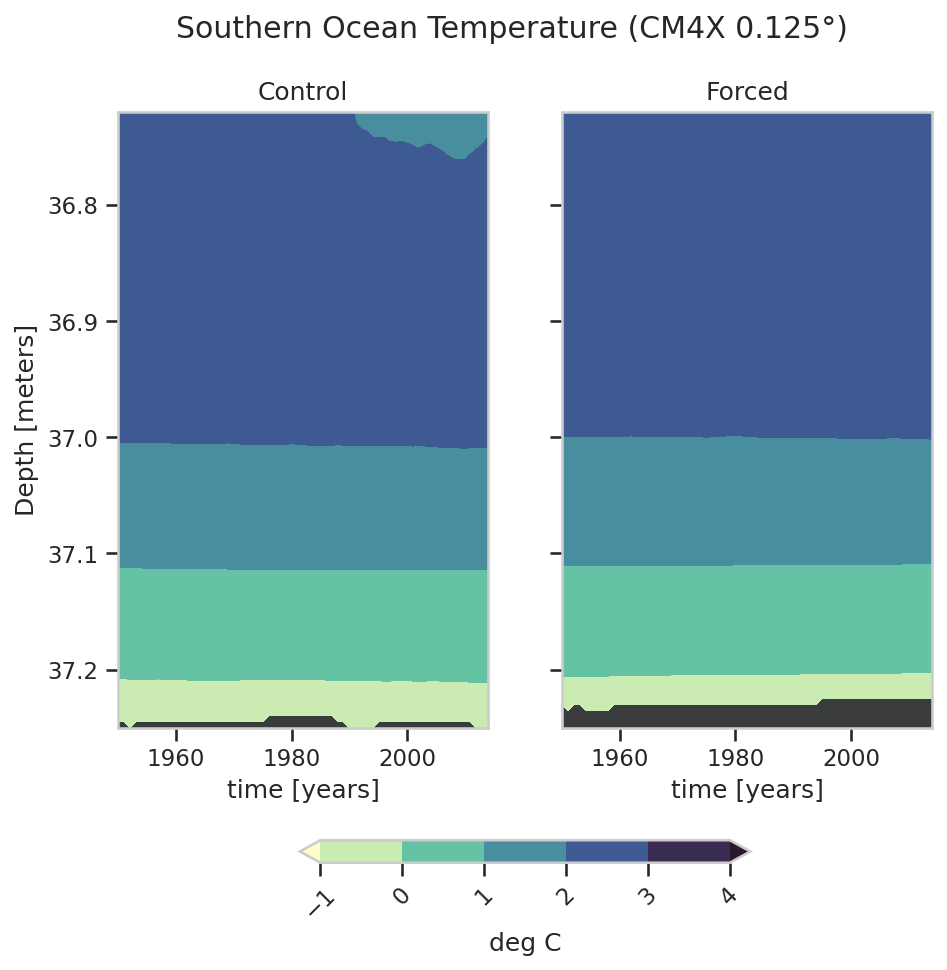

In [109]:
fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = False)
levels = np.arange(-1, 5)
tracer = "thetao"; tracername = "Temperature"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

tmp1 = interp_ctrl_timeseries[[tracer]]
tmp1 = tmp1.sel(year = slice(1950, 2014)) 
ax[0].contourf(tmp1.year, tmp1.sigma2, tmp1[tracer], cmap = cmo.deep, extend = "both", levels = levels)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

tmp2 = interp_hist_timeseries[[tracer]]
tmp2 = tmp2.sel(year = slice(1950, 2014)) 
cm = ax[1].contourf(tmp2.year, tmp2.sigma2, tmp2[tracer], cmap = cmo.deep, extend = "both", levels = levels)
cs = ax[1].clabel(cnt2, inline=True, fontsize=10)
ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
[a.set_ylim(36.72, 37.25) for a in ax]

[a.invert_yaxis() for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cm, ax = ax[0:2], label = variable_kwargs[tracer]["units"], 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)

# fig.savefig(plotsdir("paper_figures/SouthernOceanTemperature.png"), bbox_inches = "tight", dpi = 100)

In [131]:
siglevels = np.arange(36.2, 37.4, .2) 
siglevels = 1.0 * np.sort(np.append(siglevels, [37.11, 37.21, 37.22, 37.23, 37.24]))
siglevels

array([36.2 , 36.4 , 36.6 , 36.8 , 37.  , 37.11, 37.2 , 37.21, 37.22,
       37.23, 37.24])

<xarray.DataArray 'sigma2' (sigma2: 480)> Size: 4kB
array([35.   , 35.005, 35.01 , ..., 37.385, 37.39 , 37.395])
Coordinates:
  * sigma2   (sigma2) float64 4kB 35.0 35.01 35.01 35.02 ... 37.39 37.39 37.4

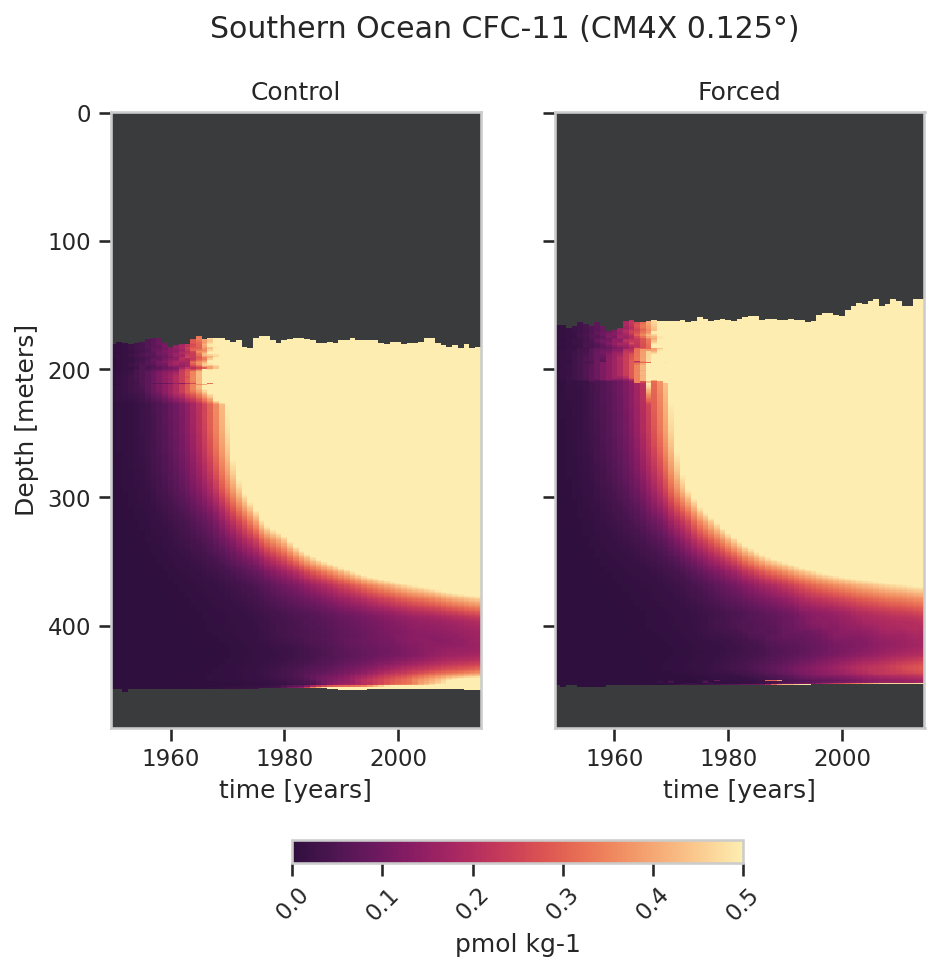

In [137]:
fig, ax = plt.subplots(1, 2, figsize = (7, 6.5), sharey = False)
levels = np.arange(0, 1.51, 0.25)
tracer = "cfc11"; tracername = "CFC-11"
fig.suptitle(f"Southern Ocean {tracername} (CM4X 0.125°)")

tmp1 = interp_ctrl_timeseries[[tracer]]
tmp1[tracer] = tmp1[tracer] * variable_kwargs[tracer]["conversion"]
tmp1[tracer] = tmp1[tracer].where(tmp1[tracer] >= 0)

tmp1 = tmp1.sel(year = slice(1950, 2014)) 
ax[0].pcolormesh(tmp1.year, np.arange(len(tmp1.sigma2)), tmp1[tracer], cmap = cmo.matter_r, vmin = 0, vmax = 0.5)
ax[0].set_ylabel("Depth [meters]")
ax[0].set_xlabel("time [years]")
ax[0].set_title("Control")

tmp2 = interp_hist_timeseries[[tracer]]
tmp2[tracer] = tmp2[tracer] * variable_kwargs[tracer]["conversion"]
tmp2[tracer] = tmp2[tracer].where(tmp2[tracer] >= 0)

tmp2 = tmp2.sel(year = slice(1950, 2014)) 
cm = ax[1].pcolormesh(tmp2.year, np.arange(len(tmp1.sigma2)), tmp2[tracer], cmap = cmo.matter_r, vmin = 0, vmax = 0.5)
cs = ax[1].clabel(cnt2, inline=True, fontsize=10)
ax[1].set_yticklabels([])
ax[1].set_title("Forced")
ax[1].set_xlabel("time [years]")

# ax[0].set_yticks(siglevels)
[a.set_facecolor("#3A3B3C") for a in ax]
[a.grid(alpha = 0) for a in ax]
# [a.set_ylim(36.72, 37.25) for a in ax]
[a.invert_yaxis() for a in ax]
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

cbar = fig.colorbar(cm, ax = ax[0:2], label = variable_kwargs[tracer]["units"], 
                    orientation = "horizontal", fraction = 0.03)
cbar.ax.tick_params(rotation=45)

# fig.savefig(plotsdir("paper_figures/SouthernOceanTemperature.png"), bbox_inches = "tight", dpi = 100)